# Min and Max Temperatures

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.aws import execute_athena_query

sns.set()

sql = f"""
select
  min(temperature) as min_temp,
  max(temperature) as max_temp,
  avg(temperature) as mean_temp,
  cast(year as int) as year,
  cast(month as int) as month
from weather
--where (month <> '7' or temperature > -5)
group by year, month
order by year, month
"""

results_url = execute_athena_query(sql)
df = pd.read_csv(results_url)

df

,min_temp,max_temp,mean_temp,year,month
0,-9.6,29.2,6.947920,2021,12
1,-8.2,15.7,5.235704,2022,1
2,-28.6,16.6,6.272091,2022,2
3,-9.0,20.4,7.028136,2022,3
4,-7.5,22.8,8.311647,2022,4
5,-1.8,26.8,11.814385,2022,5
6,-9.0,31.9,14.017357,2022,6
7,-18.0,40.2,16.697537,2022,7
8,-1.1,34.3,16.759693,2022,8
9,-2.5,40.3,13.524218,2022,9


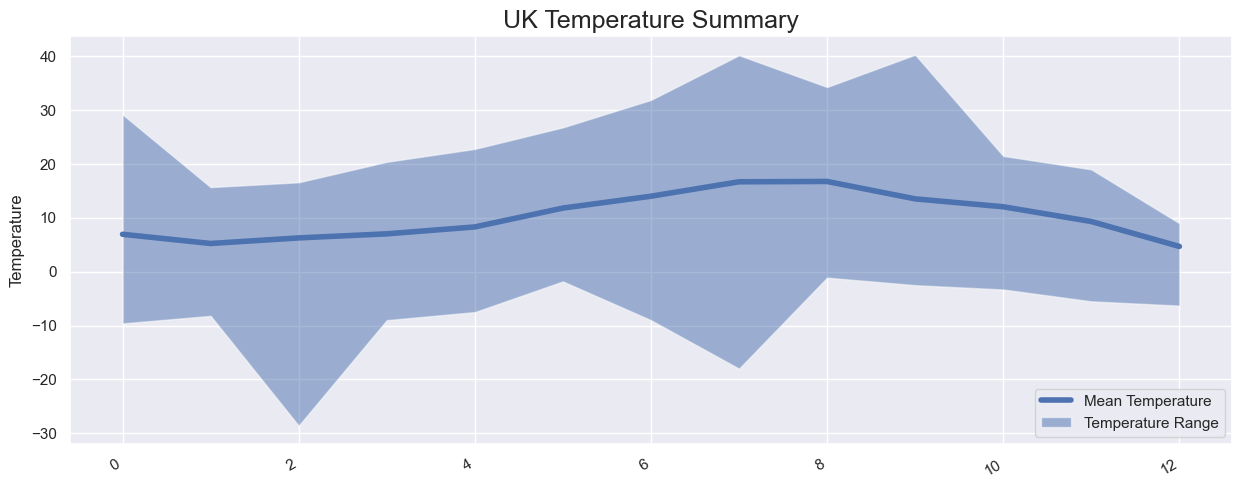

In [11]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_title('UK Temperature Summary', fontdict={'fontsize': '18', 'fontweight' : '3'})

ax.plot(df.index, df.mean_temp, linewidth=4.0, label="Mean Temperature")
ax.fill_between(df.index, df.min_temp, df.max_temp, alpha=0.5, label=f"Temperature Range")

plt.gcf().autofmt_xdate()

plt.xlabel('')
plt.ylabel('Temperature', fontsize=12)
plt.legend(loc='lower right')
plt.show()

# Finding Duplciates

## Duplicates by Partition

In [12]:
sql = f"""
select
  count(*) as num_rows,
  cast(year as int) as year,
  cast(month as int) as month,
  cast(day as int) as day
from weather
group by year, month, day
order by num_rows desc
"""

results_url = execute_athena_query(sql)
df1 = pd.read_csv(results_url)

df1.head(10)


,num_rows,year,month,day
0,6732,2021,12,15
1,3500,2022,1,21
2,3499,2022,1,20
3,3499,2022,1,15
4,3499,2022,1,11
5,3499,2022,1,13
6,3498,2022,2,6
7,3498,2022,2,5
8,3496,2022,1,14
9,3495,2022,2,7


## Duplicates by Event Time

In [13]:

sql = f"""
select
    obs_period,
    count(*) as num_rows from
    (
        select
          *,
          date_trunc('day', observation_ts) as obs_period
          from weather
    )
group by obs_period
order by num_rows desc
"""

results_url = execute_athena_query(sql)
df2 = pd.read_csv(results_url)
df2.head(10)

,obs_period,num_rows
0,2021-12-13 00:00:00.000,6199
1,2022-01-05 00:00:00.000,5278
2,2022-10-19 00:00:00.000,4839
3,2022-11-26 00:00:00.000,3664
4,2022-01-21 00:00:00.000,3500
5,2022-01-11 00:00:00.000,3499
6,2022-01-13 00:00:00.000,3499
7,2022-01-20 00:00:00.000,3499
8,2022-01-15 00:00:00.000,3499
9,2022-02-06 00:00:00.000,3498


## Distribution of row counts

Clearly most days have the 'right' number of rows, but there are a few outliers with too many or too few.

See below cumulative distribution (ECFD) and Kernel density estimation (KDE) for the number of rows vs days.

<AxesSubplot: title={'center': 'ECFD Plot'}, xlabel='num_rows', ylabel='Proportion'>

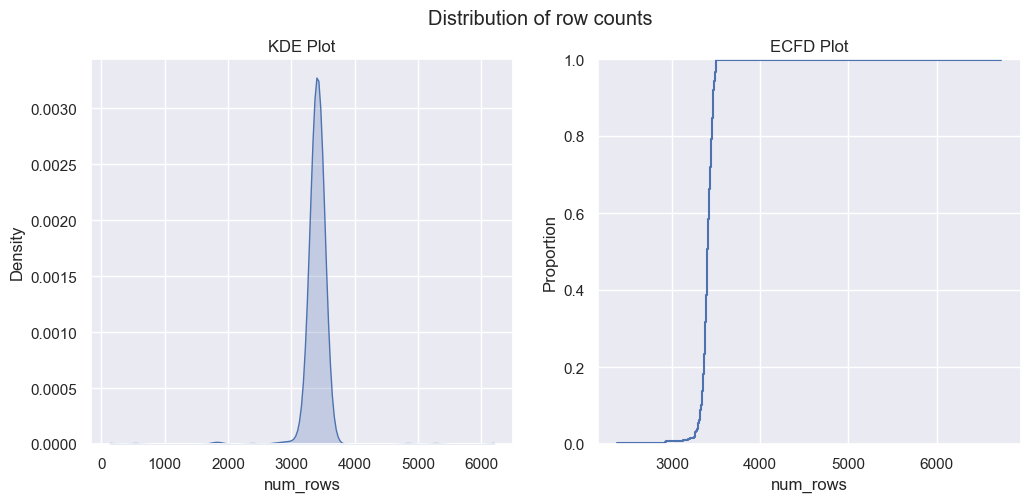

In [14]:
figure, axes = plt.subplots(1, 2, figsize=(12,5))
figure.suptitle('Distribution of row counts')
axes[0].set_title('KDE Plot')
axes[1].set_title('ECFD Plot')

sns.kdeplot(df2, ax=axes[0], x="num_rows", cut=0, fill=True)
sns.ecdfplot(df1, ax=axes[1], x="num_rows")

## Deduplication

In [15]:
sql = f"""
select
    obs_period,
    count(*) as num_rows
from
(
    select
        *,
        date_trunc('day', observation_ts) as obs_period,
        ROW_NUMBER() OVER ( partition by date_trunc('hour', observation_ts), site_id order by observation_ts desc ) as rn
       from weather
)
where rn = 1
group by obs_period
order by num_rows desc
"""

results_url = execute_athena_query(sql)
deduped_df = pd.read_csv(results_url)
deduped_df.head(5)

,obs_period,num_rows
0,2022-01-21 00:00:00.000,3360
1,2022-01-11 00:00:00.000,3360
2,2022-01-15 00:00:00.000,3360
3,2022-01-20 00:00:00.000,3359
4,2022-01-13 00:00:00.000,3359


<AxesSubplot: title={'center': 'ECFD Plot'}, xlabel='num_rows', ylabel='Proportion'>

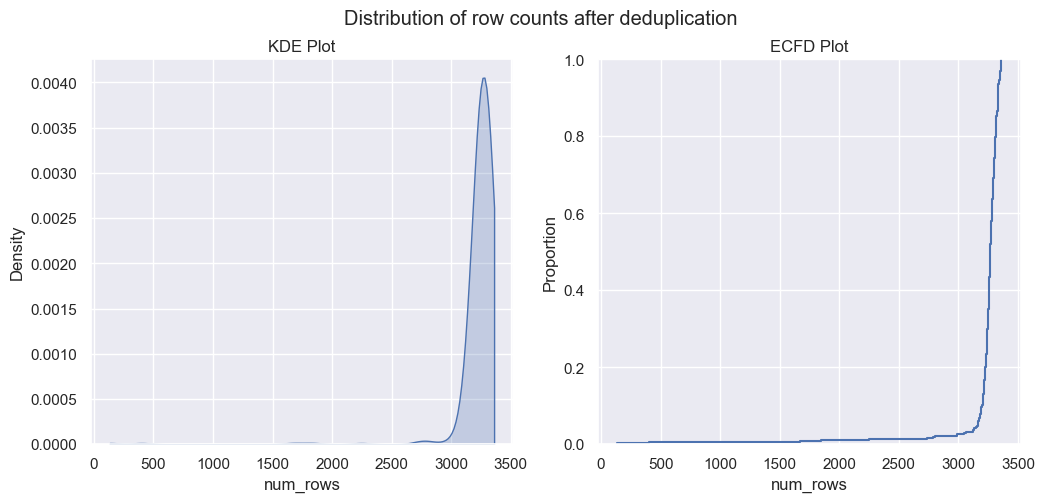

In [16]:
figure, axes = plt.subplots(1, 2, figsize=(12,5))
figure.suptitle('Distribution of row counts after deduplication')
axes[0].set_title('KDE Plot')
axes[1].set_title('ECFD Plot')

sns.kdeplot(deduped_df, ax=axes[0], x="num_rows", cut=0, fill=True)
sns.ecdfplot(deduped_df, ax=axes[1], x="num_rows")

### Days with less than 90% of expected rows

In [17]:
highest = deduped_df.num_rows.max() # Somewhat lazy way to get the max possible number of measurements in a day - doesn't account for sites added and removed over time etc
low_cutoff = round(highest * 0.90)

low_days = deduped_df[deduped_df.num_rows < low_cutoff].sort_values(by=['num_rows'])
low_days["percentage"] = round(low_days["num_rows"] * 100 / highest)

print(f"Max value: {highest} Cutoff @ 90%: {low_cutoff} Number of days below cutoff: {len(low_days)} which is {round(len(low_days) * 100 / len(df2), 2)}% of the total")

low_days

Max value: 3360 Cutoff @ 90%: 3024 Number of days below cutoff: 9 which is 2.55% of the total


,obs_period,num_rows,percentage
352,2022-12-04 00:00:00.000,134,4.0
351,2021-12-12 00:00:00.000,402,12.0
350,2022-01-04 00:00:00.000,1667,50.0
349,2022-10-20 00:00:00.000,1843,55.0
348,2022-11-16 00:00:00.000,2246,67.0
347,2022-11-27 00:00:00.000,2732,81.0
346,2022-10-24 00:00:00.000,2783,83.0
345,2022-06-14 00:00:00.000,2800,83.0
344,2022-08-11 00:00:00.000,2985,89.0


### Days with duplicated data

In [18]:
high_cutoff = highest
high_days = df2[df2.num_rows > high_cutoff].sort_values(by=['num_rows'], ascending=False)
print(f"Number of days above max: {len(high_days)} which is {round(len(high_days) * 100 / len(df2), 2)}% of the total")

high_days["percentage"] = round(high_days["num_rows"] * 100 / highest)

high_days

Number of days above max: 284 which is 80.45% of the total


,obs_period,num_rows,percentage
0,2021-12-13 00:00:00.000,6199,184.0
1,2022-01-05 00:00:00.000,5278,157.0
2,2022-10-19 00:00:00.000,4839,144.0
3,2022-11-26 00:00:00.000,3664,109.0
4,2022-01-21 00:00:00.000,3500,104.0
...,...,...,...
279,2022-10-21 00:00:00.000,3363,100.0
280,2022-10-17 00:00:00.000,3361,100.0
281,2022-09-16 00:00:00.000,3361,100.0
282,2022-10-27 00:00:00.000,3361,100.0
